In [1]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


In [2]:
malla = Mesh.load("../Eigenfunction_Stokes/data/Ugeom.obj", force_meshio_type='triangle')

In [3]:
nodes  = malla.p
facets = malla.facets
boundary_facets = malla.boundary_facets()
boundary_nodes = malla.boundary_nodes()

In [4]:
pared   = []
salida  = []
entrada = []
for i,e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    nodox = nodes[0, facets_e]
    nodoy = nodes[1, facets_e]
    m = np.array([np.mean(nodox), np.mean(nodoy)])

    if m[1] > -2.0:
        pared.append(e)
    if m[1] <= -2.0 and m[0] > 0.0:
        salida.append(e)
    if m[1] <= -2.0 and m[0] < 0.0:
        entrada.append(e)

pared = np.array(pared)
salida = np.array(salida)
entrada = np.array(entrada)
coordenadas = nodes[:, boundary_nodes]

In [5]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla, element['u'], intorder=4),
    'p': Basis(malla, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [6]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M = asm(mass_matrix, basis_u)
F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F   = np.hstack([F_u, F_p])

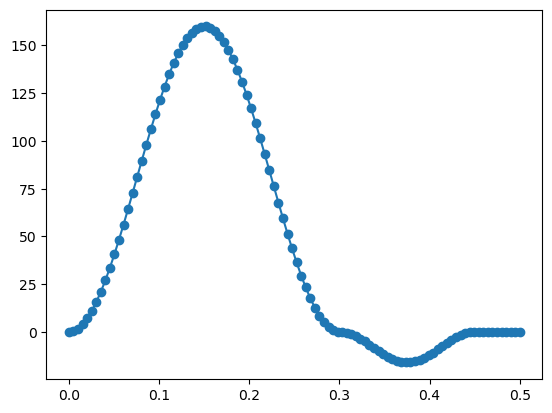

In [7]:
T_s = 0.3
T_d = 0.15
U = -160
U_dia = -16

def f_t(t):
    if t < T_s:
        return U * (np.sin(np.pi * t / T_s))**2
    elif t < T_s + T_d:
        return -U_dia * (np.sin(np.pi * (t - T_s) / T_d))**2
    else:
        return 0.0
    
def u_inflow(t, x, y):
    return f_t(t) * (x+0.5)*(x+0.02)

t = np.linspace(0, 0.5, 100)

plt.plot(t, [-f_t(ti) for ti in t], '-o')
    

In [8]:
dofs_entrada  = basis_u.get_dofs(entrada).all()
dofs_salida   = basis_u.get_dofs(salida).all()
dofs_p_salida = basis_p.get_dofs(salida).all()

xout   = basis_u.doflocs[0, dofs_salida[::2]] 
yout   = basis_u.doflocs[1, dofs_salida[1::2]]
xin   = basis_u.doflocs[0, dofs_entrada[::2]]
yin   = basis_u.doflocs[1, dofs_entrada[1::2]]

x_boundaries = np.zeros(Nu+Np)

x_boundaries[Nu + dofs_p_salida[0]] = 0.0

D_all = np.concatenate([
    basis_u.get_dofs(pared).all(),
    Nu+np.array([dofs_p_salida[0]])
]) 

In [9]:
def apply_inflow(x_boundary, dofs_boundary, dofs_top, xtop, ytop, t):
    x_boundary[dofs_entrada[::2]]  =  0.0
    x_boundary[dofs_entrada[1::2]] =  u_inflow(t, xtop, ytop)  # componente x # componente y
    dofs_boundary = np.concatenate([dofs_boundary, dofs_entrada])
    return x_boundary, dofs_boundary

In [10]:
mu      = 0.035
rho     = 1.06
delta_t = 0.001
t = np.arange(0, 0.5, delta_t)

u_n_1 = np.zeros(Nu)
U_list = []
P_list = []

for ti in t:
    x_b, dofs_b = apply_inflow(x_boundaries, D_all, entrada, xin, yin, ti)
    u_0 = basis_u.interpolate(u_n_1)  
    C   = asm(convection, basis_u, w=u_0)

    K = bmat([[M + delta_t*(mu * A + C), delta_t*B.T/rho],
             [B,         None]], format='csr')
    
    F_u = M@u_n_1
    F = np.hstack([F_u, np.zeros(Np)])

    sol = solve(*condense(K, F, D=dofs_b, x=x_b))

    u_n_1 = sol[:Nu]
    U_list.append(u_n_1)
    P_list.append(sol[Nu:])

In [38]:
import pandas as pd
data_U_ns_transient = pd.DataFrame(np.array(U_list))
data_P_ns_transient = pd.DataFrame(np.array(P_list))

data_U_ns_transient.to_csv('data_U_transient.csv', index=False)
data_P_ns_transient.to_csv('data_P_transient.csv', index=False)

In [11]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

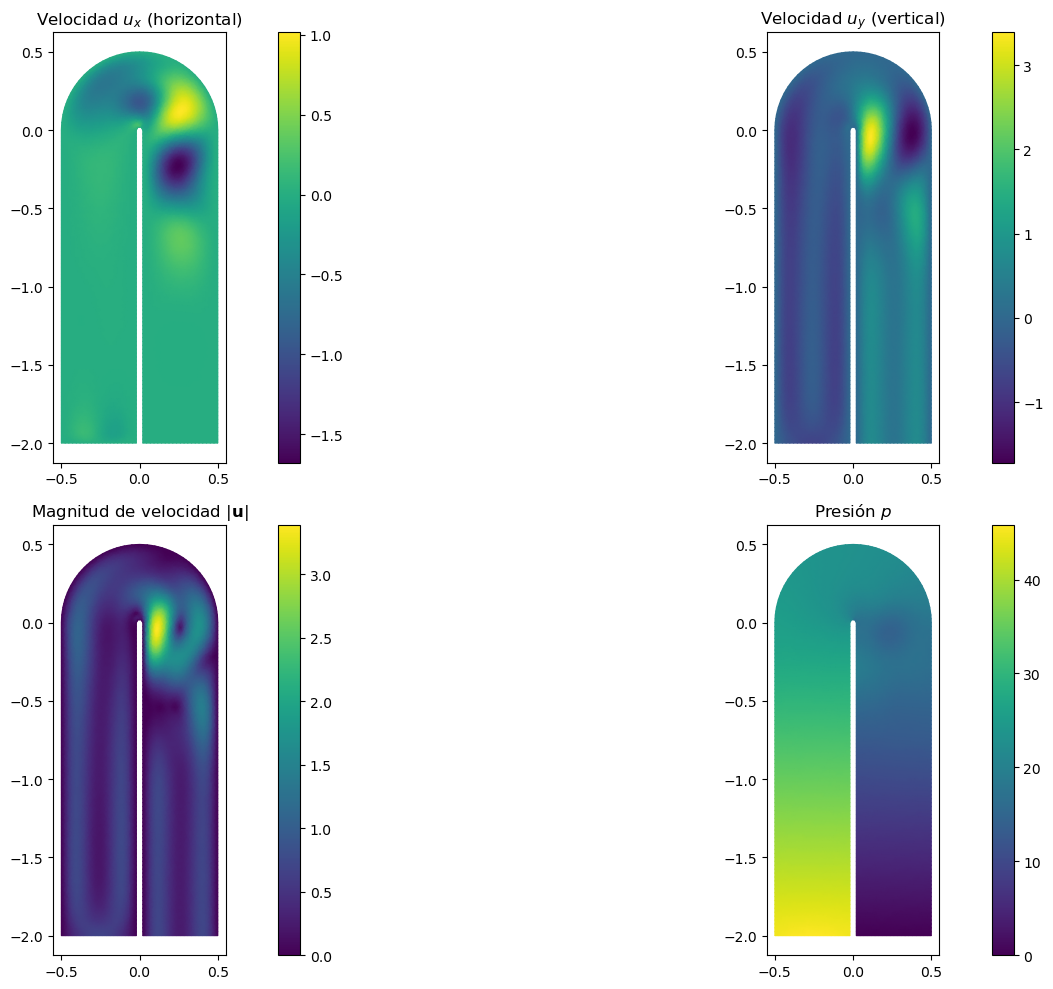

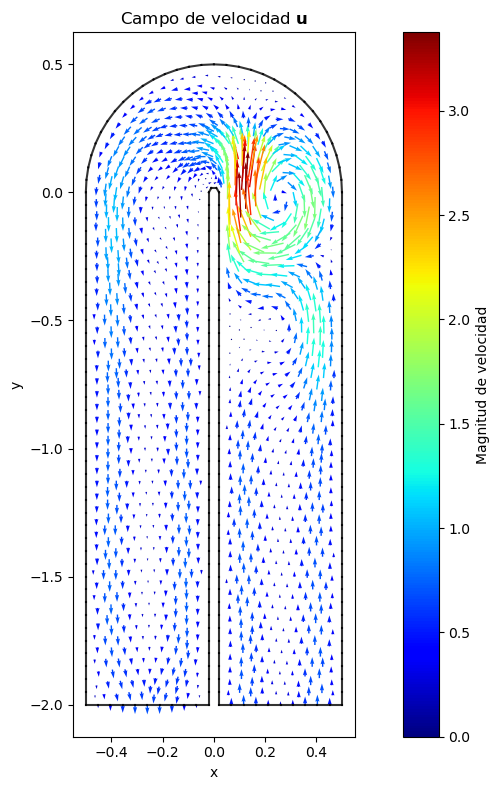

In [18]:
idx = 400
graficar_stokes(U_list[idx], P_list[idx], malla, basis_p, basis_u)

In [37]:
import matplotlib.animation as animation
from matplotlib.collections import TriMesh
import matplotlib.tri as tri

def crear_animacion_componentes(U_list, P_list, mesh, basis_u, basis_p, dt=0.001, filename='velocidad_componentes.gif', 
                                 skip_frames=1, dpi=80):
    """
    Crea GIF con presión y magnitud de velocidad (optimizado)
    
    Parameters:
    - U_list: lista de vectores de velocidad
    - P_list: lista de vectores de presión
    - skip_frames: toma cada N frames (skip_frames=2 duplica la velocidad)
    - dpi: resolución (menor = más rápido, default=80)
    """
    from skfem import Basis, ElementTriP2
    import matplotlib.pyplot as plt
    import numpy as np
    
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)
    
    # Reducir frames si es necesario
    U_list_reduced = U_list[::skip_frames]
    P_list_reduced = P_list[::skip_frames]
    dt_effective = dt * skip_frames
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Calcular límites de colorbar para presión y magnitud de velocidad
    print("Calculando límites...")
    p_min, p_max = float('inf'), float('-inf')
    umag_min, umag_max = float('inf'), float('-inf')
    
    for u_sol, p in zip(U_list_reduced, P_list_reduced):
        u_x = u_sol[0::2]
        u_y = u_sol[1::2]
        u_magnitude = np.sqrt(u_x**2 + u_y**2)
        
        p_min = min(p_min, p.min())
        p_max = max(p_max, p.max())
        umag_min = min(umag_min, u_magnitude.min())
        umag_max = max(umag_max, u_magnitude.max())
    
    # Pre-calcular geometría del dominio (solo una vez)
    nodes = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()
    
    # Pre-calcular líneas de frontera
    boundary_lines = []
    for e in boundary_facets:
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        boundary_lines.append((nodosx, nodosy))
    
    # Crear triangulación de matplotlib (solo una vez)
    triangulation = tri.Triangulation(basis_scalar.doflocs[0, :], 
                                       basis_scalar.doflocs[1, :], 
                                       basis_scalar.mesh.t.T)
    
    # Triangulación para presión (basis_p)
    triangulation_p = tri.Triangulation(basis_p.doflocs[0, :], 
                                         basis_p.doflocs[1, :], 
                                         basis_p.mesh.t.T)
    
    # Inicializar plots
    u_sol = U_list_reduced[0]
    u_x = u_sol[0::2]
    u_y = u_sol[1::2]
    u_magnitude = np.sqrt(u_x**2 + u_y**2)
    p = P_list_reduced[0]
    
    # Crear el plot inicial para presión
    tpc_p = axes[0].tripcolor(triangulation_p, p, shading='gouraud', 
                              cmap='viridis', vmin=p_min, vmax=p_max)
    
    # Crear el plot inicial para magnitud de velocidad
    tpc_u = axes[1].tripcolor(triangulation, u_magnitude, shading='gouraud', 
                              cmap='viridis', vmin=umag_min, vmax=umag_max)
    
    # Dibujar límites una sola vez en ambos subplots
    for ax in axes:
        for nodosx, nodosy in boundary_lines:
            ax.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    # Títulos y colorbars
    title_p = axes[0].set_title(r'Presión $p$ - t = 0.000s')
    title_u = axes[1].set_title(r'|Velocidad| (magnitud) - t = 0.000s')
    
    cbar_p = plt.colorbar(tpc_p, ax=axes[0])
    cbar_p.set_label(r'$p$')
    
    cbar_u = plt.colorbar(tpc_u, ax=axes[1])
    cbar_u.set_label(r'$|\mathbf{u}|$')
    
    plt.tight_layout()
    
    def update(i):
        u_sol = U_list_reduced[i]
        u_x = u_sol[0::2]
        u_y = u_sol[1::2]
        u_magnitude = np.sqrt(u_x**2 + u_y**2)
        p = P_list_reduced[i]
        
        # Actualizar los datos (mucho más rápido que redibujar)
        tpc_p.set_array(p)
        tpc_u.set_array(u_magnitude)
        
        title_p.set_text(f'Presión $p$ - t = {i*dt_effective:.3f}s')
        title_u.set_text(f'|Velocidad| (magnitud) - t = {i*dt_effective:.3f}s')
        
        if (i+1) % 10 == 0:
            print(f'Procesando frame {i+1}/{len(U_list_reduced)}', end='\r')
        
        return tpc_p, tpc_u, title_p, title_u
    
    print(f"Generando animación con {len(U_list_reduced)} frames...")
    anim = animation.FuncAnimation(fig, update, frames=len(U_list_reduced), 
                                    repeat=True, blit=True, interval=50)
    
    print(f'\nGuardando GIF...')
    anim.save(filename, writer='pillow', fps=10, dpi=dpi)
    print(f'GIF guardado como: {filename}')
    plt.close(fig)

# Uso
crear_animacion_componentes(U_list, P_list, malla, basis_u, basis_p, dt=delta_t, 
                            filename='velocidad_componentes.gif', 
                            skip_frames=5, dpi=80)

Calculando límites...
Generando animación con 100 frames...

Guardando GIF...
GIF guardado como: velocidad_componentes.gif
